In [105]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [106]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [107]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [108]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [109]:
x_pre = imputer.transform(dfpre)

In [110]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [111]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [112]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [113]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [114]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [115]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [116]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [117]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [118]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            3506 non-null   int64         
 1   Time                                  3506 non-null   datetime64[ns]
 2   LON                                   3506 non-null   float64       
 3   LAT                                   3506 non-null   float64       
 4   Temperature above oceans              3506 non-null   float64       
 5   Air density above oceans              3405 non-null   float64       
 6   Max wave height                       3152 non-null   float64       
 7   Swell period                          3152 non-null   float64       
 8   Wind wave period                      3152 non-null   float64       
 9   Wave period                           3152 non-null   float64       
 10  

Add test data for 3 months into validation data

In [120]:
# Data Splitting

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df.SOG,test_size=0.2,random_state=42)

In [121]:
df_test = pd.concat([x_test,y_test],axis=1)

In [122]:
# Extract three months of data from the test datasets

dfdate7 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-07']
dfdate8 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-08']
dfdate9 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-09']

# Concatenate 3 months data into df_ship

df_months3 = pd.concat([dfdate7,dfdate8,dfdate9])

In [123]:
df_ship = df_months3.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction,SOG
6089,286.362549,0.427317,3.749311,3.864919,3.749311,286.748657,0.230351,0.230307,2.540000e-16,5.378228,...,135.885633,20.282851,58.258534,58.572711,58.264561,0.069997,1.731313,138.004438,114.172922,20.213804
868,272.875000,4.316400,5.698798,5.554114,5.559760,276.602783,2.286533,0.381194,2.253662e+00,5.476210,...,10.475603,38.859361,162.317931,174.778947,174.857728,0.235101,12.815200,82.662809,311.997772,18.656071
1504,274.084228,0.658565,3.302223,2.298133,2.865211,275.616943,0.361897,0.248853,2.526855e-01,5.199747,...,41.869408,45.562662,156.363782,137.649488,145.804304,0.013356,4.781624,348.427831,87.520628,15.536992
4560,294.141846,0.789119,3.873077,2.441810,3.250763,293.290039,0.426860,0.317505,2.841797e-01,5.378819,...,10.388552,23.074679,173.395382,179.912091,176.190289,0.129403,5.550640,103.251379,295.937506,19.214700
4806,291.314209,0.732904,4.457611,2.140785,3.902924,291.311890,0.393402,0.338481,1.901855e-01,5.290478,...,48.463348,3.243612,167.330407,128.257759,177.653160,0.139887,5.190596,140.881400,275.661664,19.516613


In [124]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [125]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [126]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truecurrentdir','truewinddir'],axis=1)

In [127]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [128]:
X = imputer.transform(df_ship2)

In [129]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [130]:
x_months3 = df_ship2tr.drop(['sog'],axis=1)
y_months3 = df_ship2tr.sog

In [131]:
print("Amount of the test dataset is:",len(x_months3))

Amount of the test dataset is: 194


Special Section

In [132]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [133]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [134]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [135]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [136]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [137]:
stats2 = dfdate6['curspeed'].value_counts()

In [138]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [139]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [140]:
xdate = imputer.transform(dfdate6)

In [141]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [142]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truecurrentdir','truewinddir'],axis=1)
y_date = dfdate6tr.sog

In [143]:
print(f"Amount of the test dataset is {len(x_date)}")

Amount of the test dataset is 322


Reverse Modelling Test 

Concatenate test and validation data 

In [144]:
x_date_c = pd.concat([x_date,x_months3])
y_date_c = pd.concat([y_date,y_months3])

In [145]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()

    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE    

RFR evaluation

In [146]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_date,y_date)

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.7615
explained Variance = 0.7919
MAE = 0.9802
RMSE = 1.3158
MAD = 0.7254



RFR evaluation of June + 3 Months data

In [147]:
r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.8397
explained Variance = 0.8491
MAE = 0.8118
RMSE = 1.1594
MAD = 0.5851



In [148]:
r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(max_depth=200, min_samples_leaf=2, n_estimators=900,
                      random_state=42)
R^2: 0.7655
explained Variance = 0.7956
MAE = 0.9547
RMSE = 1.2999
MAD = 0.7167



In [149]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_date,y_date)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2: 0.7985
explained Variance = 0.8240
MAE = 0.9104
RMSE = 1.2188
MAD = 0.6716



In [150]:
r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=10, n_estimators=600, random_state=42)
R^2: 0.8070
explained Variance = 0.8299
MAE = 0.8941
RMSE = 1.1947
MAD = 0.6946



In [151]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr_ftr,x_date,y_date)

Model Performance of DecisionTreeRegressor()
R^2: 0.7089
explained Variance = 0.6426
MAE = 1.1324
RMSE = 1.6565
MAD = 0.8055



In [152]:
r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_date,y_date)

Model Performance of DecisionTreeRegressor(max_depth=10, max_features=12, min_samples_leaf=3)
R^2: 0.6888
explained Variance = 0.7417
MAE = 1.0764
RMSE = 1.5412
MAD = 0.7832



In [153]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr_ftr,x_date,y_date)

Model Performance of LinearRegression()
R^2: 0.3990
explained Variance = 0.4151
MAE = 1.4177
RMSE = 1.9056
MAD = 1.2112



Evaluation using Cross Validation

<Figure size 500x300 with 0 Axes>

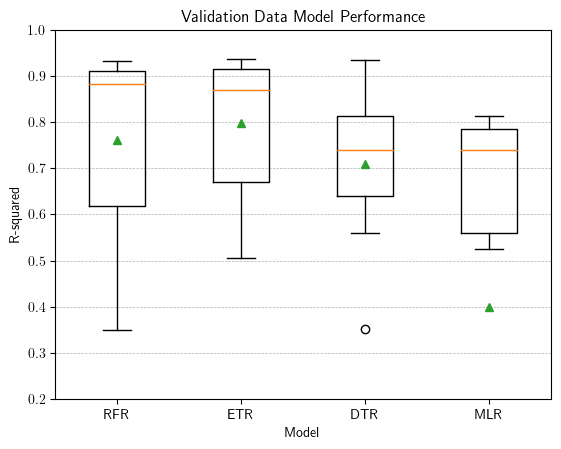

In [155]:
scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

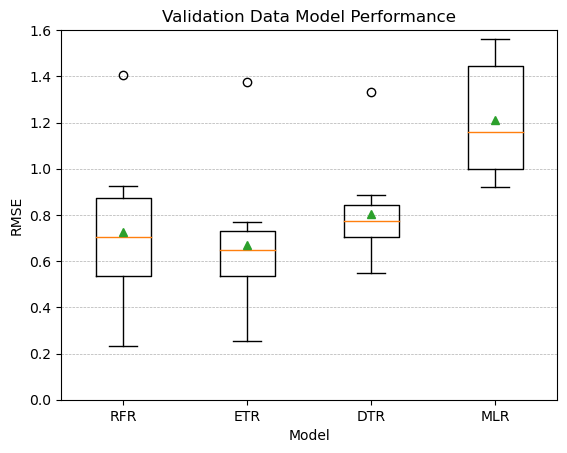

In [179]:
scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

Optimization comparison

<Figure size 500x300 with 0 Axes>

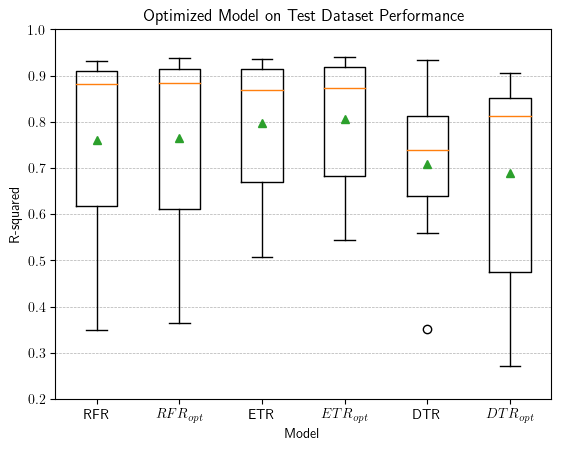

In [157]:
scores_opt = [r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

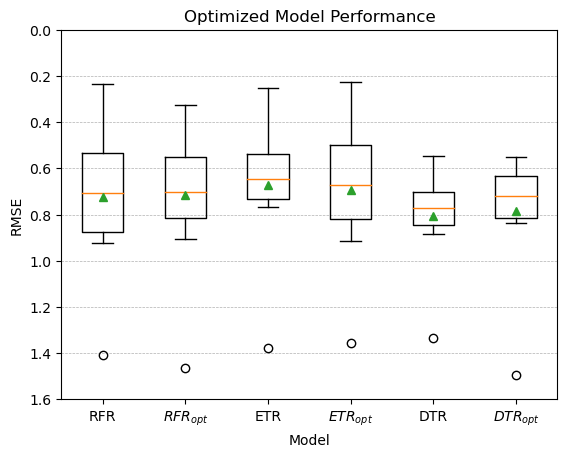

In [180]:
rmse_opt = [-RMSE_rf,-RMSE_rfo,-RMSE_et,-RMSE_eto,-RMSE_dt,-RMSE_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(1.6,0)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

In [159]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

0.5756887476858811
0.8643296965813405
y = 0.61851 * x + 6.21886
y = 0.84410 * x + 2.30175


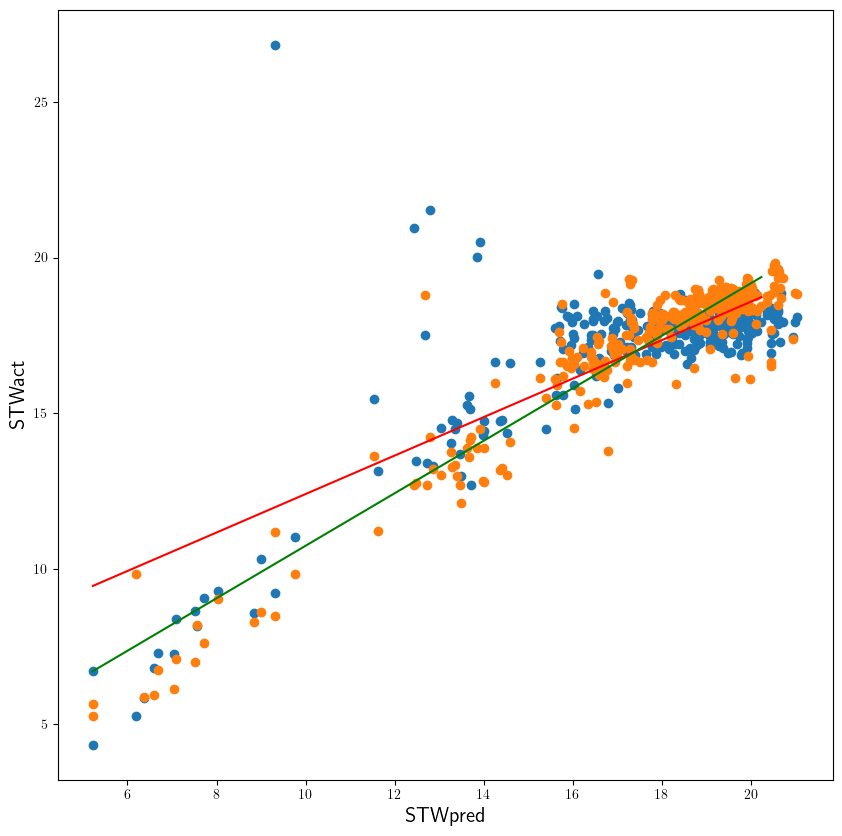

In [160]:
# fit a second degree polynomial to the economic data
from numpy import arange
from scipy.optimize import curve_fit

plt.figure(figsize=(10,10))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

y = label_predict(model_mlr_ftr,x_date)
y2 = label_predict(model_rfr_hpov,x_date)

from sklearn.metrics import r2_score

print(r2_score(y_date, y))
print(r2_score(y_date,y2))

# choose the input and output variables
x, y = y_date, y
x2, y2 = y_date, y2
# curve fit
popt, _ = curve_fit(objective, x, y)
popt2, _ = curve_fit(objective, x2, y2)

# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b ))
a2, b2 = popt2
print('y = %.5f * x + %.5f' % (a2, b2))
# plot input vs output
plt.scatter(x, y)
plt.scatter(x2, y2)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
x_line2 = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
y_line2 = objective(x_line2, a2, b2)
# create a line plot for the mapping function
plt.plot(x_line, y_line, color='red')
plt	.plot(x_line2, y_line2, color='green')
plt.xlabel('STWpred', fontsize=15)
plt.ylabel('STWact', fontsize=15)
plt.show()

STW Calculation

In [161]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

ydate_pred = label_predict(model_mlr_ftr,x_date)
 
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred       gamma    nwinddir
119   18.998906  17.742925  184.345879   21.771601
120   19.334278  17.843776  199.414773   25.671971
121   18.911047  17.865148  199.442652   32.436488
122   13.854933  20.015620  189.415252   50.510505
126    9.305198  26.829661  180.552404   74.157471
...         ...        ...         ...         ...
7413  19.072622  17.564280  104.966166  110.959927
7414  17.696584  17.411661   86.330174  126.837339
7415  15.963630  17.188227   83.486098  119.018621
7418   8.988086  10.309527   89.745593  140.723377
7419  17.672769  17.404459   15.792214  143.902554

[322 rows x 4 columns]


In [162]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,21.771601,184.345879,18.998906,17.742925,184.345879,21.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,25.671971,199.414773,19.334278,17.843776,199.414773,25.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,32.436488,199.442652,18.911047,17.865148,199.442652,32.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,50.510505,189.415252,13.854933,20.015620,189.415252,50.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,74.157471,180.552404,9.305198,26.829661,180.552404,74.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,72.289134,184.264563,20.935741,17.446812,184.264563,72.289134
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,60.000273,182.129556,12.419853,20.955455,182.129556,60.000273
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,68.405148,275.295245,20.447721,16.949770,275.295245,68.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,84.710374,187.199243,18.702889,17.374598,187.199243,84.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,89.075598,281.621166,16.155258,16.375808,281.621166,89.075598


In [163]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [164]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [165]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [166]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [167]:
# For the actual data
dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438



In [168]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,21.771601,184.345879,18.998906,17.742925,184.345879,21.771601,18.959384,17.703548
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,25.671971,199.414773,19.334278,17.843776,199.414773,25.671971,19.429024,17.938994
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,32.436488,199.442652,18.911047,17.865148,199.442652,32.436488,19.013330,17.967885
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,50.510505,189.415252,13.854933,20.015620,189.415252,50.510505,13.977521,20.134609
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,74.157471,180.552404,9.305198,26.829661,180.552404,74.157471,8.906447,26.427272
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,72.289134,184.264563,20.935741,17.446812,184.264563,72.289134,21.102027,17.613556
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,60.000273,182.129556,12.419853,20.955455,182.129556,60.000273,11.961506,20.495614
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,68.405148,275.295245,20.447721,16.949770,275.295245,68.405148,20.747280,17.249528
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,84.710374,187.199243,18.702889,17.374598,187.199243,84.710374,18.652546,17.324387
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,89.075598,281.621166,16.155258,16.375808,281.621166,89.075598,15.886581,16.107130


In [169]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.400343,287.256948,0.661506,5.282713,197.436423,189.432992,5.832751,0.092478,96.072486,193.881748,155.282564,17.449699,17.011655,155.282564,193.881748,17.462763,17.024712
std,6.306975,0.965020,4.797442,0.541832,0.162420,86.327689,88.499255,3.020207,0.068917,62.354792,89.816472,102.716811,3.069944,2.457692,102.716811,89.816472,3.087330,2.471126
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.200645,3.207821,0.112383,5.224523,4.341725,0.112383,3.207821,5.238308,4.376398
25%,285.292786,2.692099,286.832031,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,30.508970,120.064906,83.669063,16.568861,17.117509,83.669063,120.064906,16.602154,17.114012
50%,289.505615,3.160003,289.004578,0.474936,5.290842,193.360899,125.125521,5.528616,0.073482,102.070984,193.709354,129.304190,18.413643,17.681154,129.304190,193.709354,18.410164,17.695282
75%,291.391602,3.764453,290.458008,0.788779,5.381292,283.259801,279.238872,7.569939,0.123647,158.513351,279.768652,249.619550,19.421633,18.005251,249.619550,279.768652,19.454912,18.073925
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.699225,357.291804,359.450078,21.031230,26.829661,359.450078,357.291804,21.102027,26.427272


In [170]:
# FOC in T/d
dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# FOC in T/h
dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [171]:
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,...,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred,foc_act_d,foc_pred_d,foc_act_h,foc_pred_h
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,...,18.998906,17.742925,184.345879,21.771601,18.959384,17.703548,25.982496,21.153837,1.082506,0.881330
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,...,19.334278,17.843776,199.414773,25.671971,19.429024,17.938994,27.961543,22.009110,1.164958,0.916963
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,...,18.911047,17.865148,199.442652,32.436488,19.013330,17.967885,26.204915,22.115619,1.091772,0.921400
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,...,13.854933,20.015620,189.415252,50.510505,13.977521,20.134609,10.411148,31.119869,0.433758,1.296543
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,...,9.305198,26.829661,180.552404,74.157471,8.906447,26.427272,2.693529,70.366374,0.112220,2.931666
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,...,20.935741,17.446812,184.264563,72.289134,21.102027,17.613556,35.824550,20.832882,1.492554,0.867958
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,...,12.419853,20.955455,182.129556,60.000273,11.961506,20.495614,6.524779,32.823962,0.271841,1.367541
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,...,20.447721,16.949770,275.295245,68.405148,20.747280,17.249528,34.048008,19.567701,1.418538,0.815247
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,...,18.702889,17.374598,187.199243,84.710374,18.652546,17.324387,24.741303,19.823568,1.030794,0.825907
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,...,16.155258,16.375808,281.621166,89.075598,15.886581,16.107130,15.286199,15.931721,0.636867,0.663761


In [172]:
# df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
#                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
#                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
#                     'truewavedir','gamma','nwinddir'],axis=1)

df_foc=dfprog.drop(['oceantemperature','waveperiod',
                    'surftemp','windwaveswellheight',
                    'draught','cog','heading','windspeed','curspeed',
                    'truewavedir'],axis=1)

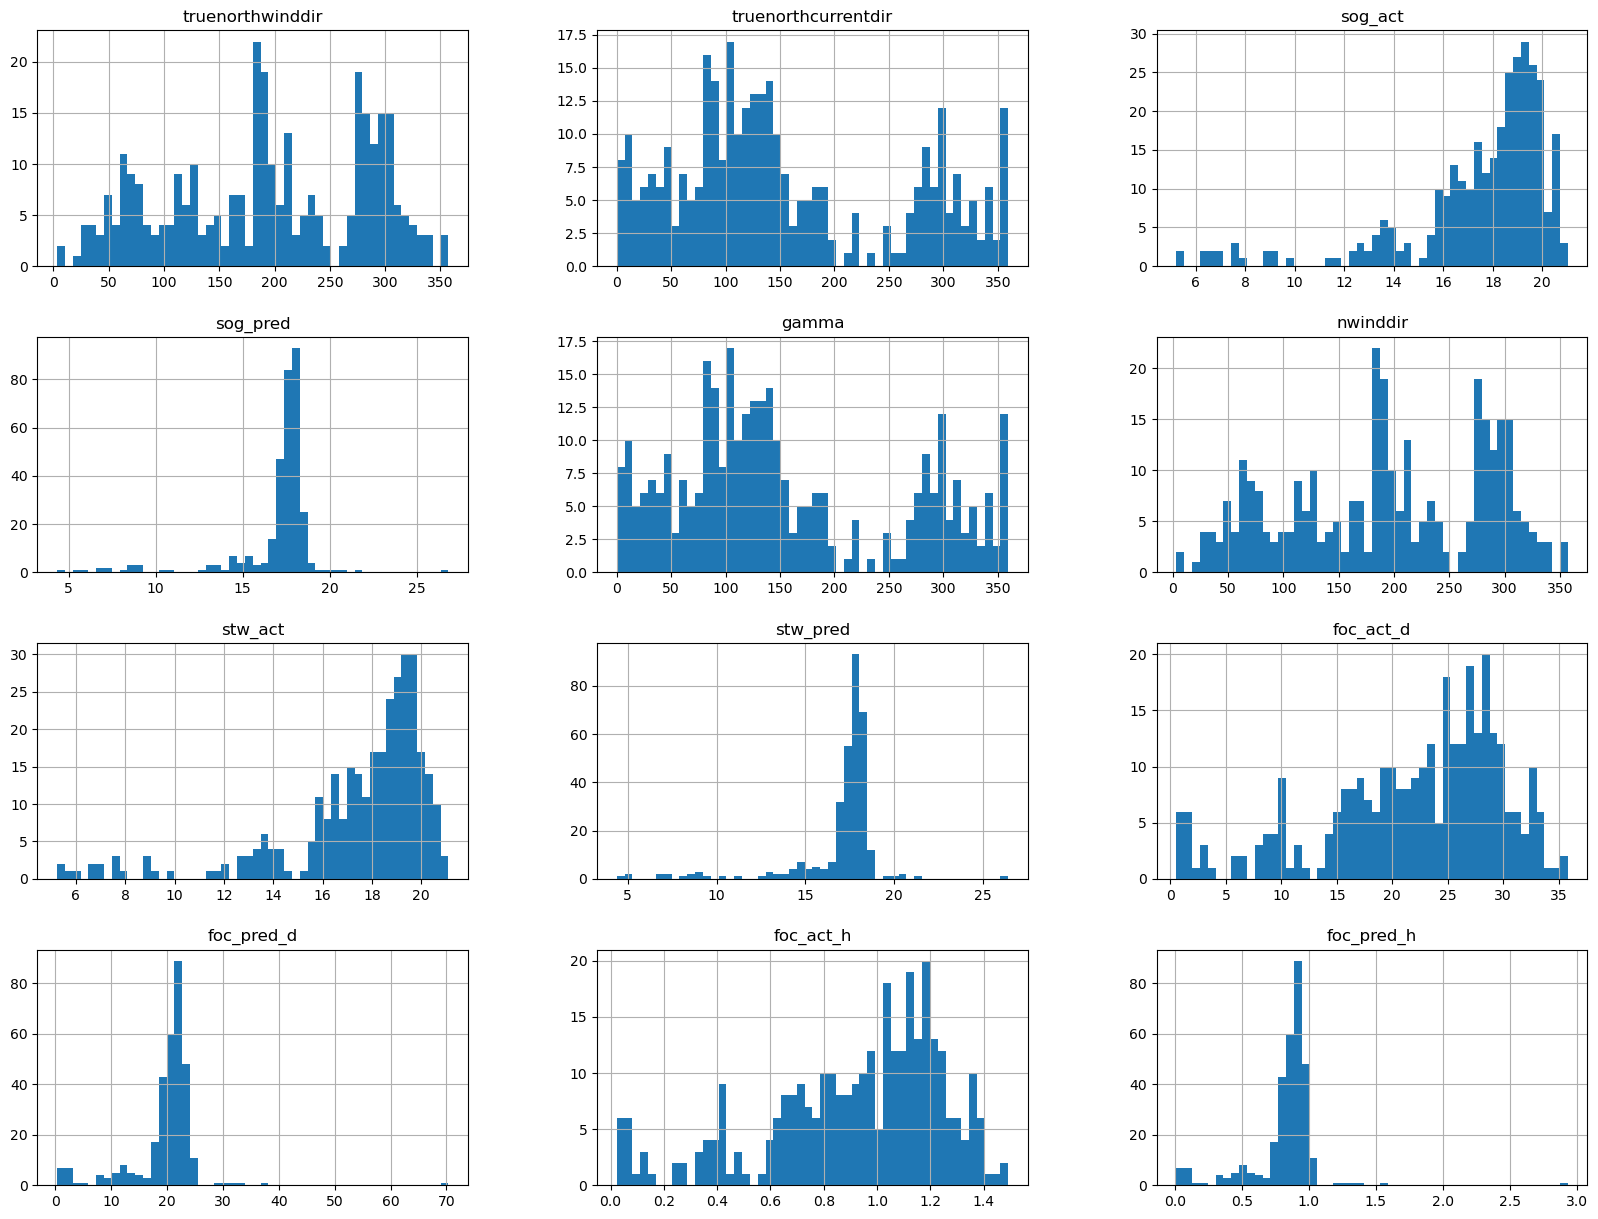

In [173]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_foc.hist(bins=50,figsize=(20,15))
plt.show()

In [174]:
foc_month = dfprog['foc_pred_d'].mean()
foc_month_a = dfprog['foc_act_d'].mean()
print(f"Mean of predicted FOC in a month is {foc_month} T/d")
print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

Mean of predicted FOC in a month is 19.84238387269712 T/d
Mean of actual FOC in a month is 21.980028002338198 T/d


In [175]:
foc_trip = dfprog['foc_pred_h'].mean() * 4
foc_trip_a = dfprog['foc_act_h'].mean() * 4
foc_trip_err = foc_trip_a - foc_trip
print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
print(f"Error is {foc_trip_err} T")

Mean of predicted FOC in a 4h trip is 3.3067636369448015 T
Mean of actual FOC in a trip in a 4h trip is 3.6630053023604194 T
Error is 0.35624166541561797 T


In [176]:
# plt.figure(figsize=(10,10))
# plt.scatter(dfprog['stw_pred'], dfprog['stw_act'], c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(dfprog['stw_pred']), max(dfprog['stw_act']))
# p2 = min(min(dfprog['stw_pred']), min(dfprog['stw_act']))
# plt.plot([p1, p2], [p1, p2], 'b-')
# # plt.xscale('linear')
# plt.xlim(0,25)
# plt.ylim(0,30)
# plt.xlabel('STW', fontsize=15)
# plt.ylabel('FOC', fontsize=15)
# # plt.axis('equal')
# plt.show()

In [177]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

y = 0.96885 * x + 0.96831


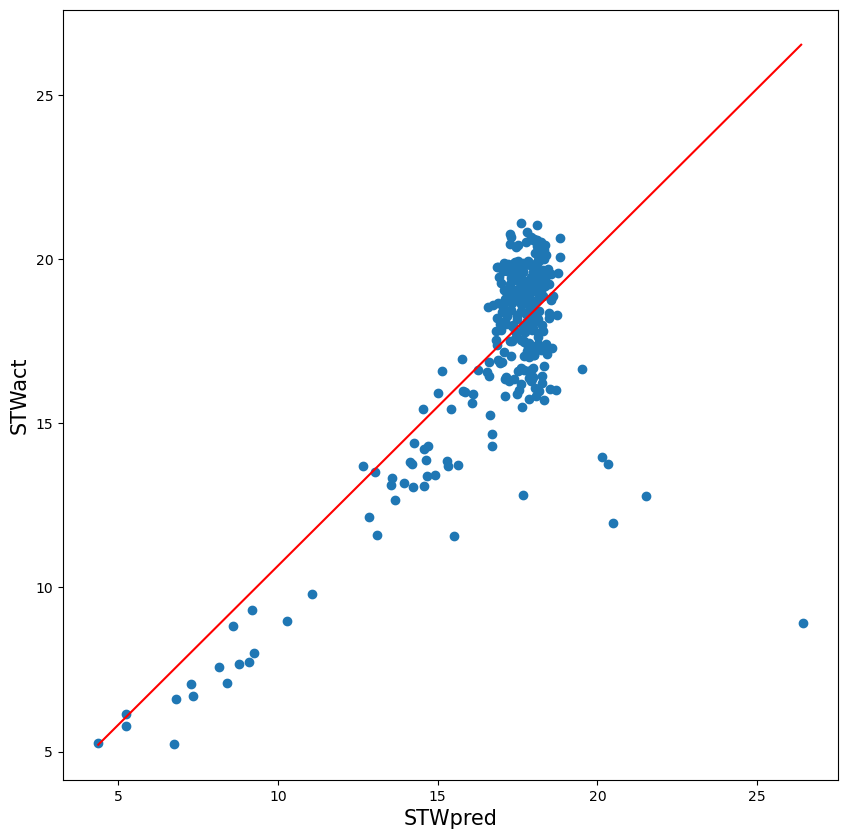

In [178]:
# fit a second degree polynomial to the economic data
from numpy import arange
from scipy.optimize import curve_fit

plt.figure(figsize=(10,10))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

# choose the input and output variables
x, y = dfprog.stw_pred, dfprog.stw_act
# x2, y2 = dfprog.stw_pred, dfprog.foc_pred_d
# curve fit
popt, _ = curve_fit(objective, x, y)
# popt2, _ = curve_fit(objective, x2, y2)

# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b ))
# a2, b2, c2 = popt2
# print('y = %.5f * x + %.5f * x^2 + %.5f' % (a2, b2, c2))
# plot input vs output
plt.scatter(x, y)
# plt.scatter(x2, y2)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# x_line2 = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
# y_line2 = objective(x_line2, a2, b2, c2)
# create a line plot for the mapping function
plt.plot(x_line, y_line, color='red')
# plt	.plot(x_line2, y_line2, color='green')
plt.xlabel('STWpred', fontsize=15)
plt.ylabel('STWact', fontsize=15)
plt.show()

y = 1.06917 * x + -0.72944

linear y = 0.96885 * x + 0.96831

